# Semantic Segmentation on Google images


---



## Description

The image segmentation task as the objective to identify the objective in a generic photo. This could be a multi-class or binary image segmentation: the first need to identify all the objectives in a photo, for example, the cat, the human, the table and so on; the second one need only to identify the object and what is not the object, for example the cat and the other things are "not the cat".

In this notebook we will explore the image segmentation on photovoltaic panels in multi spectral satellitar images. We will use a UNET model for the task (see later on) and compare the results to identify the best outcomes and the difference between the prediction and the truth label.

## About the dataset



### bdappv/ Root data folder
- google/ign:  One folder for each campaign
  - img/: Folder containing all the images presented to the users. This folder contains 28807 images for Google and 17325 images for IGN.
  - mask/: Folder containing all segmentations masks generated from the polygon annotations of the users. This folder contains 13303 masks for Google and 7686 masks for IGN.
- metadata.csv The .csv  file with the installations' metadata.




### data/ Root data folder

- raw/ Folder containing the raw crowdsourcing data and raw metadata;
  - input-google.json: .json input data data containing all information on images and raw annotators’ contributions for both phases (clicks and polygons) during the first annotation campaign;
  - input-ign.json: .json input data containing all information on images and raw annotators’ contributions for both phases (clicks and polygons) during the second annotation campaign;
  - raw-metadata.json: .json output containing the PV systems’ metadata extracted from the BDPV database before filtering. It can be used to replicate the association between the installations and the segmentation masks, as done in the notebook metadata.
- replication/ Folder containing the compiled data used to generate the segmentation masks;
  - campaign-google/campaign-ign: One folder for each campaign
    - click-analysis.json: .json output on the click analysis, compiling raw input into a few best-guess locations for the PV arrays. This dataset enables the replication of our annotations,
    - polygon-analysis.json: .json output of polygon analysis, compiling raw input into a best-guess polygon for the PV arrays.
- validation/ Folder containing the compiled data used for technical validation.
  - campaign-google/campaign-ign: One folder for each campaign
    - click-analysis-thres=1.0.json: .json output of the click analysis with a lowered threshold to analyze the effect of the threshold on image classification, as done in the notebook annotation;
    - polygon-analysis-thres=1.0.json: .json output of polygon analysis, with a lowered threshold to analyze the effect of the threshold on polygon annotation, as done in the notebook annotations.
  - metadata.csv: the .csv file of filtered installations' metadata.

##Summary


Photovoltaic (PV) energy generation plays a crucial role in the energy transition. Small-scale, residential PV installations are deployed at an unprecedented pace, and their safe integration into the grid necessitates up-to-date, high-quality information. Overhead imagery is increasingly used to improve the knowledge of residential PV installations with machine learning models capable of automatically mapping these installations. However, these models cannot be reliably transferred from one region or imagery source to another without incurring a decrease in accuracy. To address this issue, known as distribution shift, and foster the development of PV array mapping pipelines, we propose a dataset containing aerial images, segmentation masks, and installation metadata. We provide installation metadata for more than 28000 installations. We provide ground truth segmentation masks for 13000 installations, including 7000 with annotations for two different image providers. Finally, we provide installation metadata that matches the annotation for more than 8000 installations. Dataset applications include end-to-end PV registry construction, robust PV installations mapping, and analysis of crowdsourced datasets.

This dataset contains the complete records associated with the article "A crowdsourced dataset of aerial images of solar panels, their segmentation masks, and characteristics", published in Scientific data. The article is accessible here : https://www.nature.com/articles/s41597-023-01951-4

These complete records consist of:

1. The complete training dataset containing RGB overhead imagery, segmentation masks and metadata of PV installations (folder bdappv),
2. The raw crowdsourcing data, and the postprocessed data for replication and validation (folder data).
---
The description above is copied from the official page of the dataset.

The dataset can be found here: https://zenodo.org/records/7358126

The paper can be found here: https://www.nature.com/articles/s41597-023-01951-4

# Import libraries & mounting Drive

---



Mounting Drive

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Import libraries

In [ ]:
# Plotting
%matplotlib inline
%reload_ext tensorboard
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import torch.optim as optim
import albumentations as A

from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler, ConcatDataset, TensorDataset, random_split
from torchvision import datasets, transforms
from torch.utils.tensorboard import SummaryWriter
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

# Utilites
import zipfile
import os
import requests
import shutil
import numpy as np
import pandas as pd
import sklearn
import random
from PIL import Image

from shutil import copyfile
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

# Wget
try:
    import wget
except ModuleNotFoundError: # Google Colab does not have wget installed by default. Hence, we do it here if necessary
    !pip install wget
    import wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=05d314845e220ef626f53db5b798132ae125059202e2048216b3bba415f41eae
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## Constant values and useful functions

URLS and directories

In [ ]:
CAMPAIGN = "/google"

if CAMPAIGN == "/google":
    OTHER_CAMPAIGN = '/ign'
else:
    if CAMPAIGN == "/ign":
        OTHER_CAMPAIGN = '/google'
    else:
        raise ValueError("Unknown campaign: please write '/google' or '/ign'")

# URLS where you can find the dataset
BDAPPV_URL = 'https://zenodo.org/records/7358126/files/bdappv.zip?download=1'
DATA_URL = 'https://zenodo.org/records/7358126/files/data.zip?download=1'

URLS = [DATA_URL, BDAPPV_URL]

# Change this to save and extract files in different directory
PARENT_DIR = '/content/drive/MyDrive/tesi/google_semantic_segmentation'
DATASET_DIR = os.path.join(PARENT_DIR, "dataset")
SAVE_DIR = os.path.join(PARENT_DIR, "dataset")
EXTRACT_DIR = os.path.join(PARENT_DIR, "dataset")
IMG_DIR = os.path.join(DATASET_DIR, "bdappv" + CAMPAIGN + "/img")
MASK_DIR = os.path.join(DATASET_DIR, "bdappv" + CAMPAIGN + "/mask")
TO_DELETE = os.path.join(DATASET_DIR, "bdappv" + OTHER_CAMPAIGN)

TRAIN_IMG_DIR = os.path.join(PARENT_DIR, "train" + "/img")
TRAIN_MASK_DIR = os.path.join(PARENT_DIR, "train" + "/mask")
VAL_IMG_DIR = os.path.join(PARENT_DIR, "validation" + "/img")
VAL_MASK_DIR = os.path.join(PARENT_DIR, "validation" + "/mask")
TEST_IMG_DIR = os.path.join(PARENT_DIR, "test" + "/img")
TEST_MASK_DIR = os.path.join(PARENT_DIR, "test" + "/mask")

# directory to save model, plots and everything else

Bunch of constants

In [ ]:
# The answer to anything
SEED = 42

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
NUM_EPOCHS = 20
NUM_WORKERS = 2
IMAGE_HEIGHT = 200
IMAGE_WIDTH = 200 # Original: 400 x 400
PIN_MEMORY = True
LOAD_MODEL = False

Useful functions

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)

In [ ]:
def explore_directories(directory):
    for root, dirs, files in os.walk(directory):
        print(f"Directory: {root}")
        print(f"Number of files: {len(files)}")
        print("-------------------------------------")

In [ ]:
def download_and_extract(url, save_dir, extract_dir):
    filename = url.split('/')[-1]
    if not os.path.exists(os.path.join(save_dir, filename)):

        with requests.get(url, stream=True) as r:
            with open(os.path.join(save_dir, filename), 'wb') as f:
                shutil.copyfileobj(r.raw, f)

        with zipfile.ZipFile(os.path.join(save_dir, filename), 'r') as zip_ref:
            print("Extracting...")
            zip_ref.extractall(extract_dir)

        print("File .zip deleted")
        os.remove(os.path.join(save_dir, filename))
    else:
        print(f"Skipping installation of {filename}. File already exists.")

In [ ]:
def add_empty_masks():
    mask_dir = MASK_DIR
    image_dir = IMG_DIR
    images_without_masks = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        mask_path = os.path.join(mask_dir, os.path.splitext(image_file)[0] + ".png")
        if not os.path.isfile(mask_path):
            image = Image.open(image_path)
            mask = Image.new("RGB", image.size, color="black")
            mask.save(mask_path)
            images_without_masks.append(image_file)
    print(f"Aggiunte {len(images_without_masks)} maschere vuote per le immagini senza maschera.")

In [ ]:
def delete_small_images():
    image_dir = IMG_DIR
    max_size = 10240 # 10 KB
    small_images = []
    for image_file in os.listdir(image_dir):
        image_path = os.path.join(image_dir, image_file)
        if os.path.isfile(image_path) and os.path.getsize(image_path) < max_size:
            os.remove(image_path)
            small_images.append(image_file)
    print(f"Eliminate {len(small_images)} immagini con dimensione inferiore a {max_size} byte.")

In [ ]:
def split_and_move(files_paths):
    for directory, file_list in files_paths:
        # Create main directory
        os.makedirs(directory, exist_ok=True)

        # Create subdirectories img., mask and no_mask (to add them later)
        img_directory = os.path.join(directory, 'img/')
        mask_directory = os.path.join(directory, 'mask/')
        no_masks_directory = os.path.join(directory, 'no_mask/')
        os.makedirs(img_directory, exist_ok=True)
        os.makedirs(mask_directory, exist_ok=True)
        os.makedirs(no_masks_directory, exist_ok=True)

        # Create file path
        file_path = os.path.join(directory, f'{os.path.basename(directory)}.txt')
        file_no_mask_path = os.path.join(directory, f'{os.path.basename(directory)}_no_masks.txt')

        # Check if file already exists
        if os.path.exists(file_path):
            print(f"Path to file already exists: {file_path}")
        else:
            print(f"Writing to file: {file_path}")
            content = []
            content_no_mask = []
            for file_name in file_list:
                image_path = os.path.join(IMG_DIR, file_name)
                mask_path = os.path.join(MASK_DIR, file_name)
                if os.path.exists(image_path) and os.path.exists(mask_path):
                    content.append(file_name)
                else:
                    if os.path.exists(image_path) and not os.path.exists(mask_path):
                        content_no_mask.append(file_name)
                    else:
                        raise ValueError("Impossible")

            # Write content to file
            with open(file_path, 'w') as file:
                file.write('\n'.join(content))

            with open(file_path, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    # Clean the line by removing leading and trailing whitespace and newline characters
                    cleaned_line = line.strip()

                    # Get the file paths for the image and mask
                    img_file_path = os.path.join(IMG_DIR, cleaned_line)
                    mask_file_path = os.path.join(MASK_DIR, cleaned_line)

                    # Check if the image and mask files exist and copy them in the new dir
                    if os.path.exists(img_file_path) and os.path.exists(mask_file_path):
                        shutil.move(img_file_path, os.path.join(img_directory, cleaned_line))
                        shutil.move(mask_file_path, os.path.join(mask_directory, cleaned_line))

                    # Write content to file
            with open(file_no_mask_path, 'w') as file:
                file.write('\n'.join(content_no_mask))

            with open(file_no_mask_path, 'r') as file:
                lines = file.readlines()
                for line in lines:
                    # Clean the line by removing leading and trailing whitespace and newline characters
                    cleaned_line = line.strip()

                    # Get the file paths for the image and mask
                    img_file_path = os.path.join(IMG_DIR, cleaned_line)

                    # Check if the image doesn't have a mask and copy them in the new dir
                    if os.path.exists(img_file_path) and not os.path.exists(mask_file_path):
                        shutil.move(img_file_path, os.path.join(no_masks_directory, cleaned_line))

            print(f"Content for {file_path} written: {len(content)} lines")

In [ ]:
def check_progress():
    if not os.path.exists(progress_file):
        with open(progress_file, 'w') as file:
            file.write('')
        return []
    else:
        with open(progress_file, 'r') as file:
            return file.readlines()

# Setting up the environment

---



This file txt helps to track the status of the setup.

In [ ]:
progress_file = os.path.join(PARENT_DIR, 'setup_progress.txt')

progress = check_progress()

Download and extract the dataset from https://zenodo.org/records/7358126

In [ ]:
step = "Downloaded and extracted the dataset.\n"

if step not in progress:

    print("Downloading the dataset... (this will take a while)")

    if not os.path.exists(PARENT_DIR):
        os.makedirs(PARENT_DIR)
    if not os.path.exists(DATASET_DIR):
        os.makedirs(DATASET_DIR)

    for url in URLS:
        print(f"Downloading data from {url}")
        download_and_extract(url, SAVE_DIR, EXTRACT_DIR)

    with open(progress_file, 'a') as file:
        file.write(step)
    progress = check_progress()

else:
    print("Dataset already downloaded.")

Dataset already downloaded.


Free space by deleting the other campaign (in our case, IGN)

In [ ]:
step = "Delete other campaign.\n"
if step not in progress:

    print("Deleting other campaign...")

    if os.path.exists(TO_DELETE):
        shutil.rmtree(TO_DELETE)
        print(f"The directory {TO_DELETE} has been successfully deleted.")

    with open(progress_file, 'a') as file:
        file.write(step)
    progress = check_progress()

else:
    print(f"The directory {TO_DELETE} does not exist or is already deleted.")

The directory /content/drive/MyDrive/tesi/google_semantic_segmentation/dataset/bdappv/ign does not exist or is already deleted.


Fiter all the images that weights less than 10 KB

In [ ]:
step = "Filter images.\n"
if step not in progress:
    print("Filtering the dataset...")
    delete_small_images()

    with open(progress_file, 'a') as file:
        file.write(step)
    progress = check_progress()

else:
    print(f"Images already filtered.")

Images already filtered.


Split the dataset into train, validation and test set

In [ ]:
step = "Split dataset.\n"
if step not in progress:
    print("Splitting dataset...")

    img_files = [file for file in os.listdir(IMG_DIR) if file.endswith(('jpg', 'jpeg', 'png', 'bmp'))]

    # Shuffle the list of image files
    random.shuffle(img_files)
    set_seed(SEED)

    # Calculate the sizes of train, validation, and test sets
    num_images = len(img_files)
    train_size = int(0.6 * num_images)  # 60% for training
    val_size = int(0.2 * num_images)    # 20% for validation
    test_size = num_images - train_size - val_size  # Remaining for testing

    train_files = img_files[:train_size]
    val_files = img_files[train_size:train_size + val_size]
    test_files = img_files[train_size + val_size:]

    # Print the number of images in each set
    print(f"Number of training images: {len(train_files)}")
    print(f"Number of validation images: {len(val_files)}")
    print(f"Number of testing images: {len(test_files)}")
    print(f"Total images: {len(train_files) + len(val_files) + len(test_files)}")

    with open(progress_file, 'a') as file:
        file.write(step)
    progress = check_progress()

else:
    print(f"Dataset already splitted already filtered.")


Dataset already splitted already filtered.


All the splits folders are created like this:
- **split.txt**: all the images into the `split/img` directory
- **no_mask.txt**: all the images without mask (we will add them later with an empty label)
- **img**: subdirectory where all the assigned images (with masks) are stored
- **mask**: subdirectory where all the masks with solar panels are stored
- **no_mask**: subdirectory where all the assigned images (without masks) are stored




In [ ]:
step = "Creating train folder\n"
if step not in progress:

    print("Splitting the dataset...")
    train_path = os.path.join(PARENT_DIR, 'train')
    files_paths = [(train_path, train_files)]

    split_and_move(files_paths)

    with open(progress_file, 'a') as file:
        file.write(step)
    progress = check_progress()

else:
    print(f"Train folder exists.")

Train folder exists.


In [ ]:
step = "Creating validation folder\n"
if step not in progress:

    print("Splitting the dataset...")
    val_path = os.path.join(PARENT_DIR, 'validation')
    files_paths = [(val_path, val_files)]

    split_and_move(files_paths)

    with open(progress_file, 'a') as file:
        file.write(step)
    progress = check_progress()

else:
    print(f"Validation folder exists.")

Validation folder exists.


In [ ]:
step = "Creating test folder\n"
if step not in progress:

    print("Splitting the dataset...")
    test_path = os.path.join(PARENT_DIR, 'test')
    files_paths = [(test_path, test_files)]

    split_and_move(files_paths)

    with open(progress_file, 'a') as file:
        file.write(step)
    progress = check_progress()

else:
    print(f"Train folder exists.")

Train folder exists.


In [ ]:
explore_directories(PARENT_DIR)

Directory: /content/drive/MyDrive/tesi/google_semantic_segmentation
Number of files: 3
-------------------------------------
Directory: /content/drive/MyDrive/tesi/google_semantic_segmentation/.ipynb_checkpoints
Number of files: 0
-------------------------------------
Directory: /content/drive/MyDrive/tesi/google_semantic_segmentation/dataset
Number of files: 0
-------------------------------------
Directory: /content/drive/MyDrive/tesi/google_semantic_segmentation/dataset/data
Number of files: 0
-------------------------------------
Directory: /content/drive/MyDrive/tesi/google_semantic_segmentation/dataset/data/raw
Number of files: 2
-------------------------------------
Directory: /content/drive/MyDrive/tesi/google_semantic_segmentation/dataset/data/replication
Number of files: 0
-------------------------------------
Directory: /content/drive/MyDrive/tesi/google_semantic_segmentation/dataset/data/replication/campaign-google
Number of files: 2
-------------------------------------
Di

# Exploratory Data Analysis


---



# U-Net

---



## Description

The U-Net architecture is a convolutional neural network (CNN) designed for image segmentation tasks, especially in biomedical image analysis. Key features are:
- Encoder-Decoder Architecture: U-Net follows an encoder-decoder architecture. The encoder part consists of convolutional and pooling layers that downsample the input image, capturing hierarchical features. The decoder part consists of up-convolutional layers that perform upsampling to produce a segmentation map.

- Skip Connections: U-Net introduces skip connections between corresponding encoder and decoder layers. These connections allow the decoder to access high-resolution feature maps from the encoder, aiding in precise localization during segmentation. The skip connections concatenate feature maps from the encoder with upsampled feature maps from the decoder.

- Contracting Path (Encoder): The contracting path of U-Net consists of multiple convolutional layers followed by max-pooling layers. These layers progressively reduce the spatial dimensions of the input image while increasing the number of feature channels, capturing increasingly abstract features.

- Expansive Path (Decoder): The expansive path of U-Net consists of up-convolutional layers (also known as transposed convolutions or deconvolutions) that perform upsampling of feature maps. These layers gradually increase the spatial dimensions of the feature maps back to the original input size.

- Final Layer: The final layer of U-Net typically consists of a convolutional layer with a softmax activation function for multi-class segmentation or a sigmoid activation function for binary segmentation. This layer produces the final segmentation mask, with each pixel representing the probability of belonging to a particular class (for multi-class segmentation) or the foreground/background (for binary segmentation).

- Loss Function: U-Net is trained using a loss function appropriate for the segmentation task, such as cross-entropy loss for multi-class segmentation or binary cross-entropy loss for binary segmentation. The model is trained using backpropagation to minimize the loss between the predicted segmentation mask and the ground truth mask.

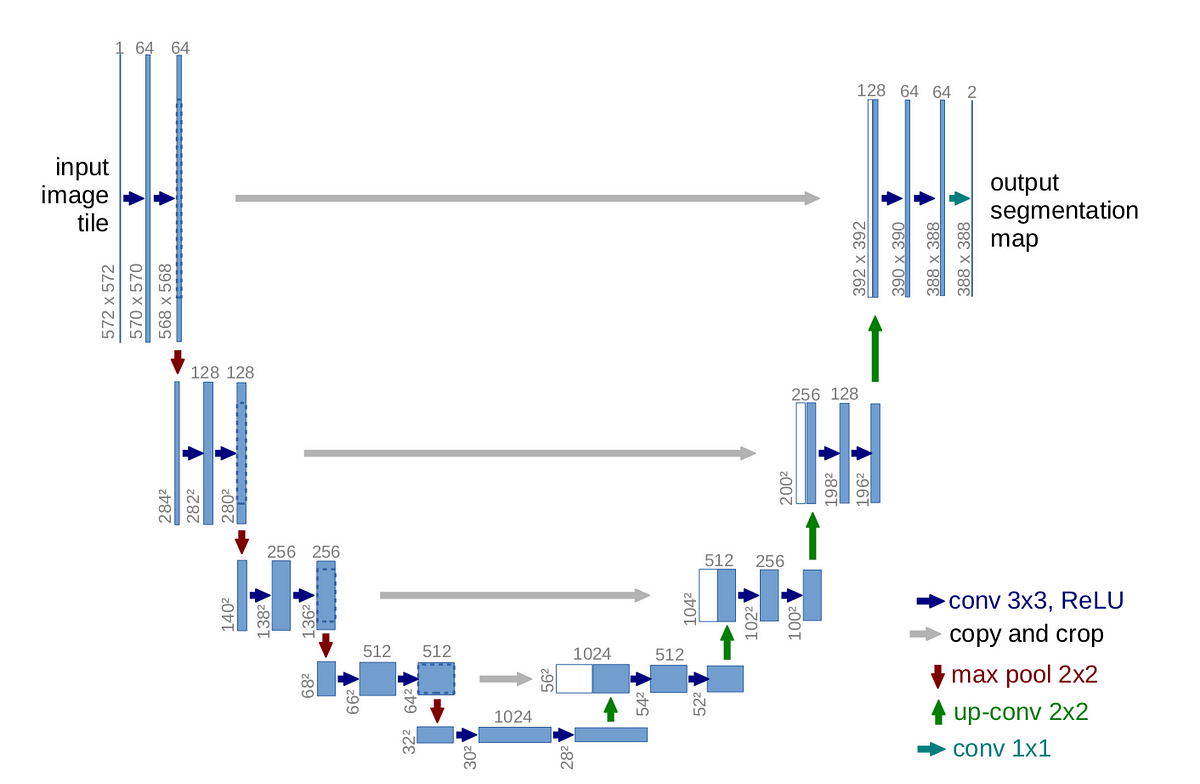

## Implementation

In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2)
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        x = self.final_conv(x)
        return x

Test on dummy input

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
dummy_input = torch.randn(1, 3, 256, 256).squeeze(1).to(DEVICE)
output = model(dummy_input)

print("Test on dummy input")
print("Output: ", output.shape)
print("Input: ", dummy_input.shape)

# Training baseline

In [ ]:
baseline_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

train_set = GoogleDataset(image_dir = TRAIN_IMG_DIR, mask_dir = TRAIN_MASK_DIR, transform = baseline_transform)
val_set = GoogleDataset(image_dir = VAL_IMG_DIR, mask_dir = VAL_MASK_DIR, transform = baseline_transform)
test_set = GoogleDataset(image_dir = TEST_IMG_DIR, mask_dir = TEST_MASK_DIR, transform = baseline_transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False,)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False,)

In [ ]:
model = UNET().to(DEVICE)
loss_values = []
predictions = []

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
step_size = (NUM_EPOCHS // 3) + 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size)
criterion = nn.BCELoss()

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0
    running_dice = 0.0

    print(f'Start training EPOCH {epoch+1}')
    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(DEVICE)
        masks = masks.float().unsqueeze(1).to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images).to(DEVICE)

        preds = torch.sigmoid(outputs)
        loss = criterion(preds, masks)

        loss.backward()
        optimizer.step()
        scheduler.step()  # Update learning rate

        running_loss += loss.item() * images.size(0)

        if batch_idx % 100 == 0:  # Print every 108 batch
            print(f'Batch {batch_idx+1} in epoch [{epoch+1}/{NUM_EPOCHS}], Loss: {loss:.4f}')

    print(f'EPOCH {epoch+1} trained')

    # Start validation after each epoch
    model.eval()
    val_running_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(DEVICE)
            val_masks = val_masks.float().unsqueeze(1).to(DEVICE)

            val_outputs = model(val_images).to(DEVICE)
            val_preds = torch.sigmoid(val_outputs)
            val_loss = criterion(val_preds, val_masks)

            val_running_loss += val_loss.item() * val_images.size(0)

    epoch_loss = running_loss / len(train_loader)
    val_epoch_loss = val_running_loss / len(val_loader)
    print(f'Training Loss: {epoch_loss:.4f}')
    print(f'Validation Loss: {val_epoch_loss:.4f}')

# Training with augmentation

In [ ]:
baseline_transform = A.Compose([
    A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

train_set = GoogleDataset(image_dir = TRAIN_IMG_DIR, mask_dir = TRAIN_MASK_DIR, transform = baseline_transform)
val_set = GoogleDataset(image_dir = VAL_IMG_DIR, mask_dir = VAL_MASK_DIR, transform = baseline_transform)
test_set = GoogleDataset(image_dir = TEST_IMG_DIR, mask_dir = TEST_MASK_DIR, transform = baseline_transform)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False,)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY, shuffle=False,)

# Dump



Come modello puoi usare una semplice U-net (o altro modello a tua scelta). Un buon tutorial per implementare UNET è il seguente: https://www.youtube.com/watch?v=IHq1t7NxS8k&ab_channel=AladdinPersson.




I training che dovrai eseguire sono almeno i seguenti:
- Baseline (prova diversi learning rate su scala logaritmica, una volta individuato il migliore passa al punto successivo)
- Aggiunta di data augmentation (almeno random horizontal/vertical flip, rotazioni di 0/90/180/270 gradi)
- Per questo dataset è importante provare anche ad aggiungere RandomCrop. Questo perché i pannelli solari, se sono presenti, sono quasi sempre al centro dell'immagine, e potrebbe non generalizzare bene a un caso reale.

Salvati tutti i training / pesi / grafici che fai, li vorrò vedere all'esame per vedere il lavoro fatto e le considerazioni che hai fatto.

I modelli migliori (sul validation) usali sul test set e segnati i risultati in una tabela (IoU per ogni classe, mIoU e overall accuracy).

Creati una repository GitHub dove puoi caricare di volta in volta il codice aggiornato. (Utile anche per dimostrare che il lavoro fatto è originale)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimizer_SGD = torch.optim.SGD(model.parameters(), lr=0.01)

step_size = (NUM_EPOCHS // 3) + 1
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size)
criterion = nn.BCEWithLogitsLoss()

In questo modo il learning rate viene moltiplicato di default per 0.1 dopo un terzo delle epoche e di novo a due terzi del training e aiuta a convergere su un risultato migliore, permettendo anche di usare un learning rate iniziale maggiore.